In [1]:
import pandas as pd
df = pd.read_csv(r"D:\Downloads\ar_properties.csv\ar_properties.csv")

In [2]:
df.property_type.value_counts()

property_type
Departamento       427958
Casa               227300
Lote               110081
Otro                91371
PH                  44743
Local comercial     43351
Oficina             32529
Cochera             13010
Depósito             7674
Casa de campo        1983
Name: count, dtype: int64

In [3]:
df = df[df.property_type.isin(['Casa','Departamento', 'Casa de campo', 'PH']) & (df.price>=10000) & (df.price<=1000000)]

In [4]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].set_crs(epsg=4326)

gdf.l2.value_counts()

l2
Capital Federal                 176907
Bs.As. G.B.A. Zona Sur           90644
Bs.As. G.B.A. Zona Norte         78330
Bs.As. G.B.A. Zona Oeste         48511
Buenos Aires Costa Atlántica     45201
Santa Fe                         39702
Córdoba                          34805
Buenos Aires Interior             9081
Neuquén                           5770
Montevideo                        4024
Maldonado                         3863
Mendoza                           3298
Tucumán                           2780
Río Negro                         2609
Salta                             2597
Entre Ríos                        2378
Misiones                          1043
San Luis                           695
Chubut                             652
Chaco                              574
Corrientes                         497
Canelones                          488
Florida                            439
Colonia                            408
San Juan                           352
Tierra Del Fuego      

In [5]:
gdf = gdf[
    gdf.l2.isin(['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Oeste'])
    & (gdf.currency=='USD') & (gdf.operation_type=='Venta')
]

# Dificil calcular el pm2...
gdf['pm2_properati'] = gdf.price / gdf.surface_covered
gdf.surface_covered.isna().sum() / gdf.shape[0]

0.4562842410570416

<Axes: ylabel='Frequency'>

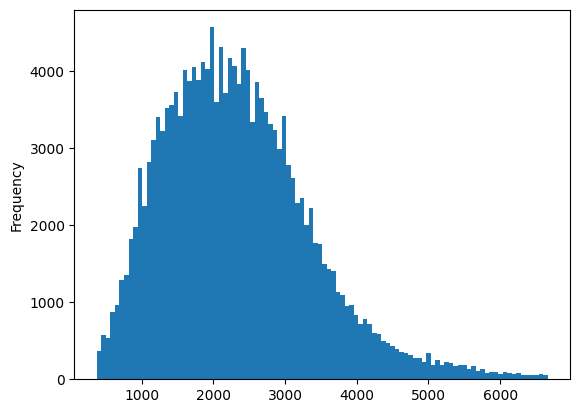

In [6]:
gdf[(gdf.pm2_properati < gdf.pm2_properati.quantile(.995)) & 
    (gdf.pm2_properati > gdf.pm2_properati.quantile(.005))]['pm2_properati'].plot(kind='hist', bins=100)

In [21]:
import numpy as np

# Compute logs of price and meter squared price
gdf['log_price'] = np.log(gdf.price)
gdf['log_pm2_properati']   = np.log(gdf.pm2_properati)


In [ ]:
# Plot deciles of pm2
gdf["pm2_properati_q"] = pd.qcut(gdf.pm2_properati, 10, labels=False)
gdf.sample(10000).explore(column='pm2_properati_q')

In [ ]:
# Plot deciles of pm2
gdf["price_q"] = pd.qcut(gdf.price, 10, labels=False)
gdf.sample(10000).explore(column='price_q')

## Colapse data by census tract

In [29]:
icpag = gpd.read_file(r"D:\Maestría\Tesis\Repo\data\data_in\ICPAG\base_icpag_500k.shp")
collapse_link = pd.read_stata(fr"D:\Maestría\Tesis\Repo\data\data_in\predict_ingreso_collapse.dta")

# Merge icpag indicators with ELL estimation
icpag['link'] = icpag['link'].astype(str).str.zfill(9)
collapse_link['link'] = collapse_link['link'].astype(str).str.zfill(9)

icpag = icpag.merge(collapse_link, on='link', how='left', validate='1:1')

In [31]:
icpag = icpag[['link', 'pm2', 'p_usd', 'geometry', 'icpag', 'pred_inc_mean']]

In [53]:
agg = icpag.sjoin(gdf, how='inner', op='intersects').groupby('link').agg({'pm2':'mean', 'p_usd':['mean', 'median'], 'icpag':'mean', 'price':['mean','count','median'], 'pm2_properati':['mean','median'], 'icpag':'first', 'geometry':'first', 'pred_inc_mean':'first'})

C:\Users\ofici\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py:3508: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



In [56]:
# Drop column level by merging names
agg.columns = agg.columns.map('_'.join)

In [57]:
agg = agg.rename(columns={'geometry_first':'geometry'})
agg = gpd.GeoDataFrame(agg, geometry='geometry')

In [35]:
agg

pm2_mean     p_usd_mean  icpag_first  price_mean  price_count  \
link                                                                          
020010101  2348.729736  187153.045759         0.30    227700.0           10   
020010201          NaN            NaN         0.07    125000.0            1   
020010204          NaN            NaN         0.13    250000.0            1   
020010208          NaN            NaN         0.03    250000.0            1   
020010214          NaN            NaN         0.07     87000.0            1   
...                ...            ...          ...         ...          ...   
821190418   766.995361  105879.512500         0.53     52000.0            1   
821190506   915.776245  138231.999254         0.58    259500.0            2   
821190804   619.714478  104614.477214         0.57     62000.0            2   
821190806   648.652771  129292.563477         0.54     48000.0            1   
901190314   698.168884  187691.350781         0.69    110000.0            1   

           price_median  pm2_properati_mean  pm2_properati_median  \
link                                                                
020010101      205000.0         3146.318118           3451.327434   
020010201      125000.0         2232.142857           2232.142857   
020010204      250000.0         2450.980392           2450.980392   
020010208      250000.0         2500.000000           2500.000000   
020010214       87000.0         2230.769231           2230.769231   
...                 ...                 ...                   ...   
821190418       52000.0          262.626263            262.626263   
821190506      259500.0         1770.952381           1770.952381   
821190804       62000.0          623.006135            623.006135   
821190806       48000.0          872.727273            872.727273   
901190314      110000.0          852.713178            852.713178   

                                                    geometry  \
link                                                           
020010101  POLYGON ((-58.37425 -34.57870, -58.36795 -34.5...   
020010201  POLYGON ((-58.38915 -34.57818, -58.38888 -34.5...   
020010204  POLYGON ((-58.38557 -34.57822, -58.38546 -34.5...   
020010208  POLYGON ((-58.38165 -34.58231, -58.38158 -34.5...   
020010214  POLYGON ((-58.37561 -34.58419, -58.37588 -34.5...   
...                                                      ...   
821190418  POLYGON ((-60.72100 -32.81297, -60.71943 -32.8...   
821190506  POLYGON ((-60.97528 -32.88735, -60.91827 -32.8...   
821190804  POLYGON ((-60.72207 -32.81992, -60.72140 -32.8...   
821190806  POLYGON ((-60.72364 -32.82165, -60.72335 -32.8...   
901190314  POLYGON ((-65.32824 -26.79924, -65.32205 -26.8...   

           pred_inc_mean_first  
link                            
020010101           818.702332  
020010201           621.090332  
020010204           539.215393  
020010208           456.911377  
020010214           589.111145  
...                        ...  
821190418           536.913086  
821190506           539.130188  
821190804           592.304260  
821190806           589.939209  
901190314           634.696045  

[11950 rows x 10 columns]

In [26]:
agg[agg['price_count']>50][['pm2_properati_median', 'pm2_mean']].corr()

pm2_properati_median  pm2_mean
pm2_properati_median              1.000000  0.912852
pm2_mean                          0.912852  1.000000

In [27]:
import numpy as np
agg['ln_price_median'] = agg.price_median.apply(np.log)
agg[agg.pm2_properati_median.notna() & (agg['price_count']>20) & (agg.ln_price_median < agg.ln_price_median.quantile(.998))].set_crs(epsg=4326).explore(column='ln_price_median', cmap='Spectral_r')

In [28]:
agg

pm2_mean     p_usd_mean  icpag_first  price_mean  price_count  \
link                                                                          
20010101   2348.729736  187153.045759         0.30    227700.0           10   
20010201           NaN            NaN         0.07    125000.0            1   
20010204           NaN            NaN         0.13    250000.0            1   
20010208           NaN            NaN         0.03    250000.0            1   
20010214           NaN            NaN         0.07     87000.0            1   
...                ...            ...          ...         ...          ...   
821190418   766.995361  105879.512500         0.53     52000.0            1   
821190506   915.776245  138231.999254         0.58    259500.0            2   
821190804   619.714478  104614.477214         0.57     62000.0            2   
821190806   648.652771  129292.563477         0.54     48000.0            1   
901190314   698.168884  187691.350781         0.69    110000.0            1   

           price_median  pm2_properati_mean  pm2_properati_median  \
link                                                                
20010101       205000.0         3146.318118           3451.327434   
20010201       125000.0         2232.142857           2232.142857   
20010204       250000.0         2450.980392           2450.980392   
20010208       250000.0         2500.000000           2500.000000   
20010214        87000.0         2230.769231           2230.769231   
...                 ...                 ...                   ...   
821190418       52000.0          262.626263            262.626263   
821190506      259500.0         1770.952381           1770.952381   
821190804       62000.0          623.006135            623.006135   
821190806       48000.0          872.727273            872.727273   
901190314      110000.0          852.713178            852.713178   

                                                    geometry  ln_price_median  
link                                                                           
20010101   POLYGON ((-58.37425 -34.57870, -58.36795 -34.5...        12.230765  
20010201   POLYGON ((-58.38915 -34.57818, -58.38888 -34.5...        11.736069  
20010204   POLYGON ((-58.38557 -34.57822, -58.38546 -34.5...        12.429216  
20010208   POLYGON ((-58.38165 -34.58231, -58.38158 -34.5...        12.429216  
20010214   POLYGON ((-58.37561 -34.58419, -58.37588 -34.5...        11.373663  
...                                                      ...              ...  
821190418  POLYGON ((-60.72100 -32.81297, -60.71943 -32.8...        10.858999  
821190506  POLYGON ((-60.97528 -32.88735, -60.91827 -32.8...        12.466512  
821190804  POLYGON ((-60.72207 -32.81992, -60.72140 -32.8...        11.034890  
821190806  POLYGON ((-60.72364 -32.82165, -60.72335 -32.8...        10.778956  
901190314  POLYGON ((-65.32824 -26.79924, -65.32205 -26.8...        11.608236  

[11950 rows x 10 columns]

In [47]:
# agg[agg.pm2_properati_median.notna() & (agg['price_count']>20) & (agg.ln_price_median < agg.ln_price_median.quantile(.998))]
agg.loc[agg['price_count']>20, ['pm2_mean', 'pm2_properati_mean', 'icpag_first', 'pred_inc_mean_first']].corr('spearman')

pm2_mean  pm2_properati_mean  icpag_first  \
pm2_mean             1.000000            0.881515     0.725049   
pm2_properati_mean   0.881515            1.000000     0.657590   
icpag_first          0.725049            0.657590     1.000000   
pred_inc_mean_first  0.838317            0.761692     0.832494   

                     pred_inc_mean_first  
pm2_mean                        0.838317  
pm2_properati_mean              0.761692  
icpag_first                     0.832494  
pred_inc_mean_first             1.000000

In [58]:
# agg[agg.pm2_properati_median.notna() & (agg['price_count']>20) & (agg.ln_price_median < agg.ln_price_median.quantile(.998))]
agg.loc[agg['price_count']>-10, ['p_usd_median', 'price_median', 'pm2_mean', 'pm2_properati_mean', 'icpag_first', 'pred_inc_mean_first']].corr('spearman')

p_usd_median  price_median  pm2_mean  pm2_properati_mean  \
p_usd_median             1.000000      0.709025  0.620290            0.590855   
price_median             0.709025      1.000000  0.388543            0.485714   
pm2_mean                 0.620290      0.388543  1.000000            0.877146   
pm2_properati_mean       0.590855      0.485714  0.877146            1.000000   
icpag_first              0.573141      0.433601  0.797386            0.738363   
pred_inc_mean_first      0.524773      0.380704  0.855196            0.778636   

                     icpag_first  pred_inc_mean_first  
p_usd_median            0.573141             0.524773  
price_median            0.433601             0.380704  
pm2_mean                0.797386             0.855196  
pm2_properati_mean      0.738363             0.778636  
icpag_first             1.000000             0.938912  
pred_inc_mean_first     0.938912             1.000000

In [61]:
import plotly.express as px
fig = px.scatter(agg, y='pm2_properati_median', x="pm2_mean")

# Make 5000 max value for both axis
fig.update_xaxes(range=[0, 5000])
fig.update_yaxes(range=[0, 5000])
# Change size of figure
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)

In [ ]:
gdf.sample(1000).plot(column='price')